In [1]:
%%capture
!pip install pystan

In [27]:
import stan
import pandas as pd
import numpy as np
import math
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import nest_asyncio
import arviz as az
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [28]:
rlwm_foraging_model = """
data {
  int<lower=1> N;                       // Number of trials
  int<lower=1> A;                       // Number of actions (patches)
  array[N] int<lower=1, upper=A> actions; // Chosen patch (1-based index)
  array[N] real<lower=0> rewards;       // Reward received (can be 0)
}

parameters {
  // RL Parameters
  real<lower=0, upper=1> alpha_rl;      // RL learning rate
  real<lower=0> beta_rl;                // RL inverse temperature

  // WM Parameters
  real<lower=0> beta_wm;                // WM inverse temperature
  real<lower=0, upper=1> forget;        // WM forgetting/decay rate (1 = full forget, 0 = no forget)

  // Mixture & Choice Parameters
  real<lower=0, upper=1> w;             // Mixture weight (proportion WM)
  real<lower=0, upper=1> epsilon;       // Lapse rate (random choice)
  real<lower=0> stick;                  // Stickiness parameter (positive favors repeating action)
}

model {
  alpha_rl ~ beta(1, 1);
  beta_rl ~ gamma(1, 0.2);
  beta_wm ~ gamma(1, 0.2);
  forget ~ beta(1, 1);
  w ~ beta(1, 1);
  epsilon ~ beta(1, 1);
  stick ~ normal(0, 3);

  // --- Initialization ---
  vector[A] Q = rep_vector(0.0, A);
  vector[A] WM = rep_vector(0.0, A);
  vector[A] prev_choice_vec = rep_vector(0.0, A);

  // --- Trial Loop ---
  for (t in 1:N) {
    int a = actions[t];                 // Current action (1-based)
    real r = rewards[t] / 200.0;        // Scaled reward for current trial

    // 1. Calculate Choice Probabilities
    vector[A] policy_rl_logits = beta_rl * Q + stick * prev_choice_vec;
    vector[A] policy_wm_logits = beta_wm * WM + stick * prev_choice_vec;

    // Use log_softmax for numerical stability
    vector[A] log_policy_rl;
    vector[A] log_policy_wm;

    {
      // Calculate log_softmax manually for better control
      real max_rl = max(policy_rl_logits);
      real max_wm = max(policy_wm_logits);

      // Stabilized computation
      vector[A] centered_rl_logits = policy_rl_logits - max_rl;
      vector[A] centered_wm_logits = policy_wm_logits - max_wm;

      real log_sum_exp_rl = log(sum(exp(centered_rl_logits)));
      real log_sum_exp_wm = log(sum(exp(centered_wm_logits)));

      for (k in 1:A) {
        log_policy_rl[k] = centered_rl_logits[k] - log_sum_exp_rl;
        log_policy_wm[k] = centered_wm_logits[k] - log_sum_exp_wm;
      }
    }

    // Convert from log space for mixture
    vector[A] policy_rl = exp(log_policy_rl);
    vector[A] policy_wm = exp(log_policy_wm);

    vector[A] combined_policy_no_lapse = w * policy_wm + (1 - w) * policy_rl;
    vector[A] final_policy = (1 - epsilon) * combined_policy_no_lapse + epsilon / A;

    // Ensure positive probabilities and normalization
    real norm_const = sum(final_policy);

    // Add to target the log probability of the chosen action
    // Using a small constant to avoid log(0)
    real prob_a = final_policy[a] / norm_const;
    real safe_prob = fmax(prob_a, 1e-10);
    target += log(safe_prob);

    // 3. Update RL Q-values
    real rpe = r - Q[a];
    Q[a] = Q[a] + alpha_rl * rpe;

    // 4. Update WM values
    WM = WM * (1 - forget);
    WM[a] = r;

    // 5. Update stickiness vector
    prev_choice_vec = rep_vector(0.0, A);
    prev_choice_vec[a] = 1.0;
  }
}
"""

In [29]:
def plot_mcmc_convergence_rlwm(fit_object, var_names=None, subject_id=None, block_id=None):
    """
    Plots MCMC trace plots and prints summary stats for RLWM model parameters.

    Args:
        fit_object: Output from the compiled Stan model's `.sample()` call.
        var_names (list, optional): Parameter names to include. If None, defaults to RLWM model parameters.
        subject_id (optional): Subject identifier to display in title.
        block_id (optional): Block identifier to display in title.
    """
    default_vars = ['alpha_rl', 'beta_rl', 'beta_wm', 'forget', 'w', 'epsilon', 'stick']
    var_names = var_names if var_names is not None else default_vars

    if fit_object is None:
        print("Cannot plot convergence: fit_object is None.")
        return

    # Convert to InferenceData
    if not isinstance(fit_object, az.InferenceData):
        try:
            fit_object = az.convert_to_inference_data(fit_object)
        except Exception as e:
            print(f"Error converting to InferenceData: {e}")
            return

    # Create subplots
    n_params = len(var_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

    if n_params == 1:
        axes = [axes]

    chain_colors = ['#FF7F0E', '#9467BD', '#4C2889', '#DBAF57']

    for i, var_name in enumerate(var_names):
        if var_name not in fit_object.posterior:
            print(f"Warning: '{var_name}' not found in fit object.")
            axes[i].text(0.5, 0.5, f"{var_name} not found", ha='center', va='center', transform=axes[i].transAxes)
            continue

        param_data = fit_object.posterior[var_name]

        # Handle multidimensional parameters
        if len(param_data.dims) > 2:
            flat_dims = [d for d in param_data.dims if d not in ['chain', 'draw']]
            if flat_dims:
                idx = {dim: 0 for dim in flat_dims}
                param_data = param_data.isel(**idx)

        # Plot chains
        for c in range(min(len(param_data.chain), 4)):
            chain_data = param_data.sel(chain=c)
            axes[i].plot(chain_data, color=chain_colors[c], linewidth=0.7, alpha=0.9)

        axes[i].set_title(var_name)
        axes[i].set_xlabel("Iteration")

    # Add chain legend
    handles = [plt.Line2D([0], [0], color=color, linewidth=1)
               for color in chain_colors[:min(len(fit_object.posterior.chain), 4)]]
    labels = [str(i+1) for i in range(min(len(fit_object.posterior.chain), 4))]
    fig.legend(handles, labels, title="chain", loc='upper right', bbox_to_anchor=(0.99, 0.99))

    # Set super title
    title = "MCMC Convergence"
    if subject_id is not None:
        title += f" for Subject {subject_id}"
    if block_id is not None:
        title += f", Block {block_id}" if subject_id is not None else f" for Block {block_id}"
    plt.suptitle(title)

    plt.tight_layout()
    plt.show()

    try:
        print("\nSummary Statistics (including R-hat and ESS):")
        summary = az.summary(fit_object, var_names=var_names)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            print(summary)
    except Exception as e:
        print(f"Error generating summary statistics: {e}")


In [30]:
def fit_rlwm_foraging_model(df, num_chains=4, num_samples=200):
    all_samples = []
    subject_groups = df.groupby(['subno'])

    for subject, group_data in subject_groups:
        print(f"Processing Subject: {subject}")

        stan_data = {
            'N': len(group_data),
            'A': 8,
            'actions': group_data['Patch'].values.astype(int),
            'rewards': group_data['Reward'].values.astype(float)
        }

        # Compile and sample from model
        rlwm_foraging_sm = stan.build(rlwm_foraging_model, data=stan_data)
        rlwm_fit = rlwm_foraging_sm.sample(
            num_chains=num_chains,
            num_samples=num_samples
        )

        # Plot convergence
        plot_mcmc_convergence_rlwm(
            fit_object=rlwm_fit,
            subject_id=subject,
        )

        # Extract and flatten samples
        param_names = ['alpha_rl', 'beta_rl', 'beta_wm', 'forget', 'w', 'epsilon', 'stick']
        extracted = {param: np.ravel(rlwm_fit[param]) for param in param_names}
        n_samples = len(extracted['alpha_rl'])

        # Assemble into DataFrame
        samples_df = pd.DataFrame({
            'subno': [subject] * n_samples,
            **extracted
        })
        all_samples.append(samples_df)

    return pd.concat(all_samples, ignore_index=True)


In [31]:
data = pd.read_csv('/content/Foraging_data.csv')

data['Reward'] = pd.to_numeric(data['Reward'], errors='coerce').fillna(0).astype(int)
data['subno'] = pd.to_numeric(data['subno'], errors='coerce').fillna(0).astype(int)
data['Patch'] = pd.to_numeric(data['Patch'], errors='coerce').fillna(0).astype(int)
data['Patch'] = 1 + data['Patch']

assert data['Reward'].dtype == np.int64, "Reward column must be integer type"
assert data['subno'].dtype == np.int64, "subno column must be integer type"

Processing Subject: (1,)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:   1% (200/20000)
Sampling:   2% (300/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1901/20000)
Sampling:  10% (2002/20000)
Sampling:  11% (2101/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000)
Sampling:  16% (

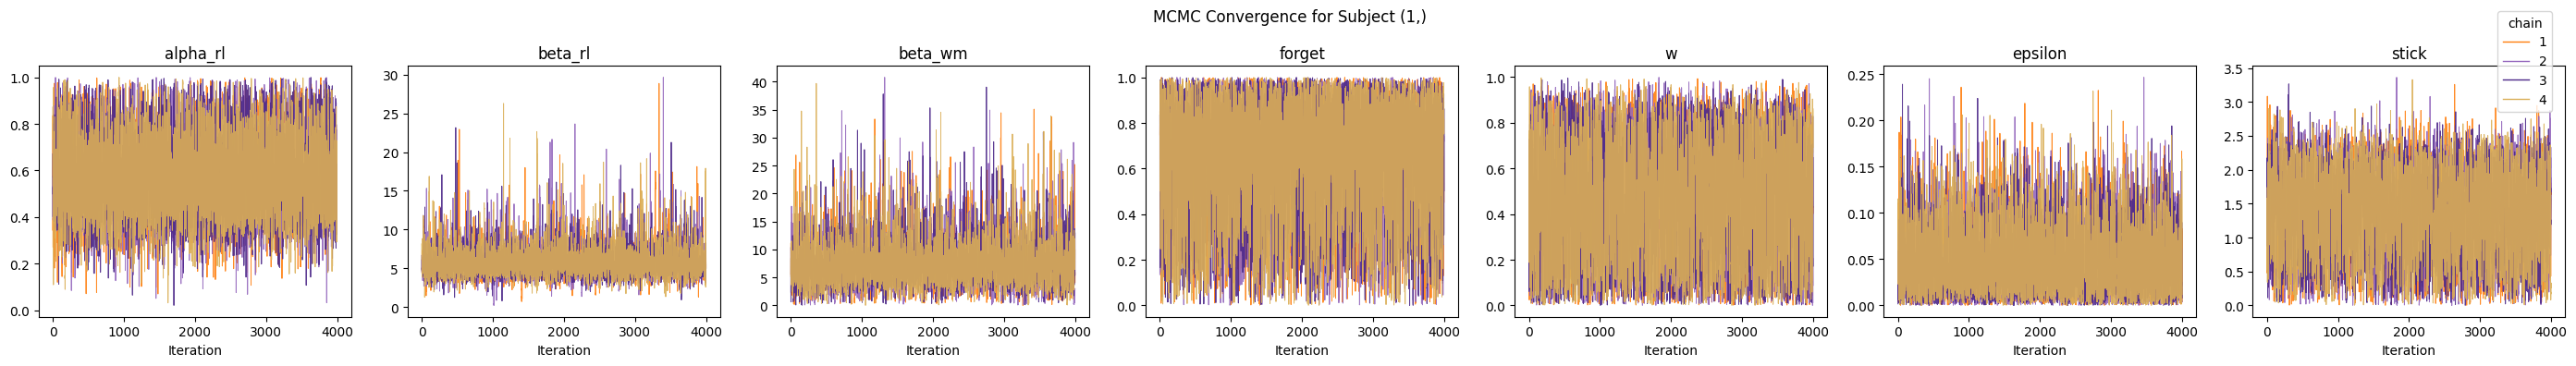


Summary Statistics (including R-hat and ESS):
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_rl  0.588  0.178   0.304    0.959      0.002    0.002    8842.0    5114.0    1.0
beta_rl   5.846  1.988   2.894    9.586      0.024    0.047    8575.0    6201.0    1.0
beta_wm   7.095  3.940   0.064   13.468      0.045    0.062    5775.0    3247.0    1.0
forget    0.653  0.255   0.167    1.000      0.003    0.002    7525.0    6805.0    1.0
w         0.457  0.260   0.004    0.846      0.004    0.002    4014.0    6170.0    1.0
epsilon   0.043  0.035   0.000    0.107      0.000    0.000    6477.0    4555.0    1.0
stick     1.352  0.638   0.106    2.329      0.010    0.005    4141.0    4673.0    1.0
Processing Subject: (2,)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:   1% (200/20000)
Sampling:   2% (300/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1901/20000)
Sampling:  10% (2002/20000)
Sampling:  11% (2101/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000)
Sampling:  16% (

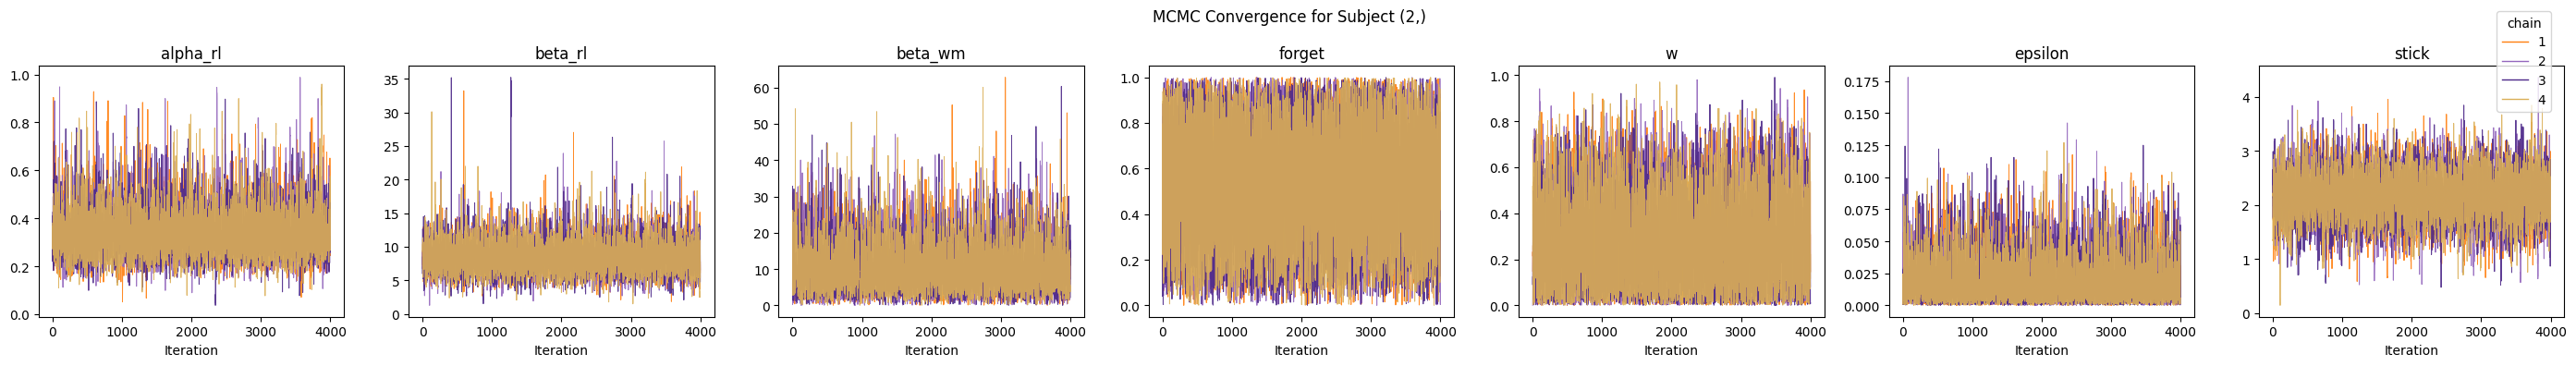


Summary Statistics (including R-hat and ESS):
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_rl  0.346  0.105   0.169    0.539      0.001    0.002    9634.0    6325.0    1.0
beta_rl   8.392  2.423   4.017   12.655      0.024    0.037    9940.0    7868.0    1.0
beta_wm   9.642  6.661   0.003   21.334      0.068    0.075    7374.0    4759.0    1.0
forget    0.540  0.269   0.113    1.000      0.002    0.002   13647.0    9193.0    1.0
w         0.257  0.200   0.000    0.618      0.002    0.002    6190.0    7762.0    1.0
epsilon   0.018  0.017   0.000    0.050      0.000    0.000   10399.0    6861.0    1.0
stick     2.140  0.449   1.287    2.996      0.006    0.005    6476.0    4575.0    1.0
Processing Subject: (3,)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:   1% (200/20000)
Sampling:   2% (300/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1801/20000)
Sampling:  10% (1901/20000)
Sampling:  10% (2000/20000)
Sampling:  11% (2101/20000)
Sampling:  11% (2201/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000)
Sampling:  16% (

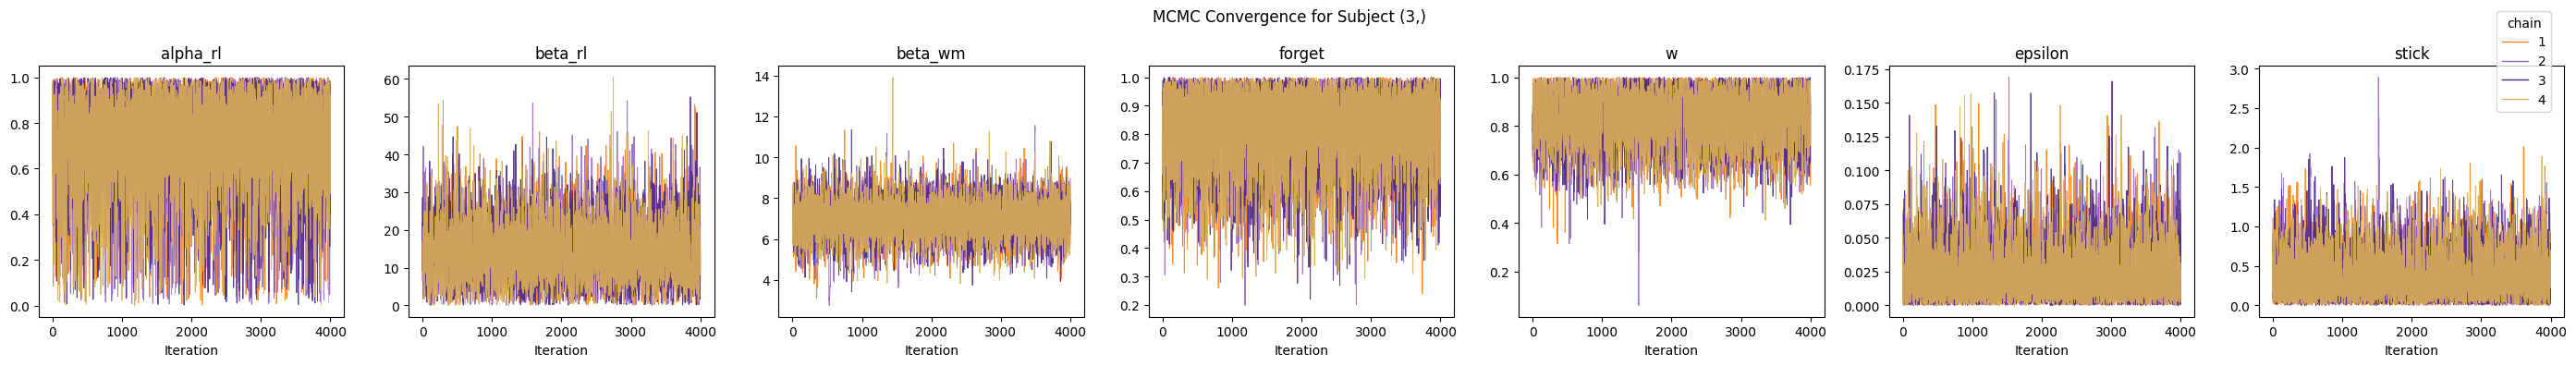


Summary Statistics (including R-hat and ESS):
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_rl   0.716  0.219   0.298    1.000      0.002    0.002    8135.0    6902.0    1.0
beta_rl   12.869  7.573   0.031   25.458      0.088    0.065    5702.0    4046.0    1.0
beta_wm    6.916  0.953   5.114    8.756      0.013    0.015    6131.0    4165.0    1.0
forget     0.836  0.132   0.592    1.000      0.001    0.001    9125.0    6032.0    1.0
w          0.854  0.108   0.669    1.000      0.002    0.002    4305.0    5885.0    1.0
epsilon    0.020  0.020   0.000    0.056      0.000    0.000    8126.0    5790.0    1.0
stick      0.353  0.305   0.000    0.914      0.004    0.006    5390.0    5608.0    1.0
Processing Subject: (4,)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:   1% (200/20000)
Sampling:   2% (300/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1901/20000)
Sampling:  10% (2002/20000)
Sampling:  11% (2101/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000)
Sampling:  16% (

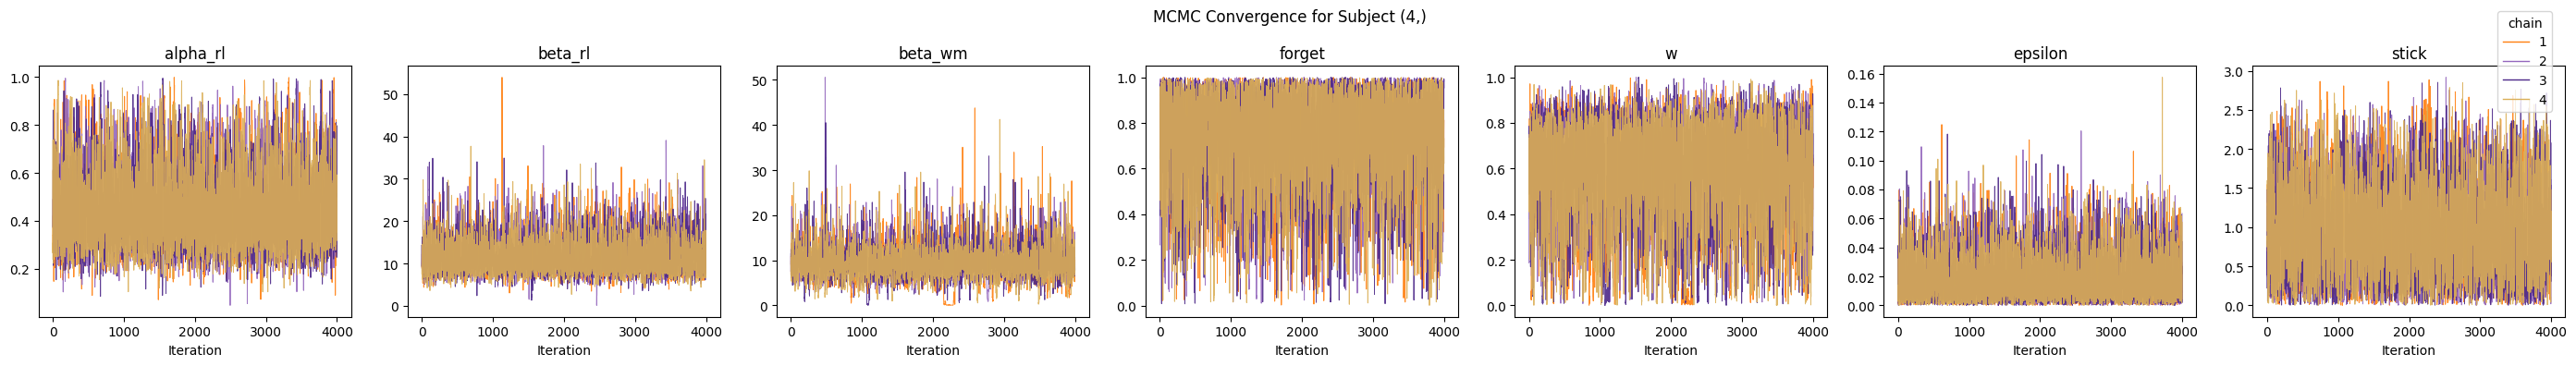


Summary Statistics (including R-hat and ESS):
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_rl   0.456  0.160   0.188    0.771      0.002    0.002    7153.0    4566.0    1.0
beta_rl   11.620  3.971   5.539   19.220      0.053    0.057    4803.0    4523.0    1.0
beta_wm    9.452  3.588   2.883   16.769      0.102    0.114    1177.0     398.0    1.0
forget     0.742  0.211   0.330    1.000      0.004    0.003    3830.0    3756.0    1.0
w          0.569  0.220   0.080    0.905      0.006    0.006    1460.0     443.0    1.0
epsilon    0.017  0.015   0.000    0.045      0.000    0.000    7025.0    4939.0    1.0
stick      0.945  0.602   0.001    1.976      0.014    0.008    1935.0    2346.0    1.0
Processing Subject: (5,)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   1% (101/20000)
Sampling:   1% (200/20000)
Sampling:   2% (300/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1901/20000)
Sampling:  10% (2002/20000)
Sampling:  11% (2101/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000)
Sampling:  16% (

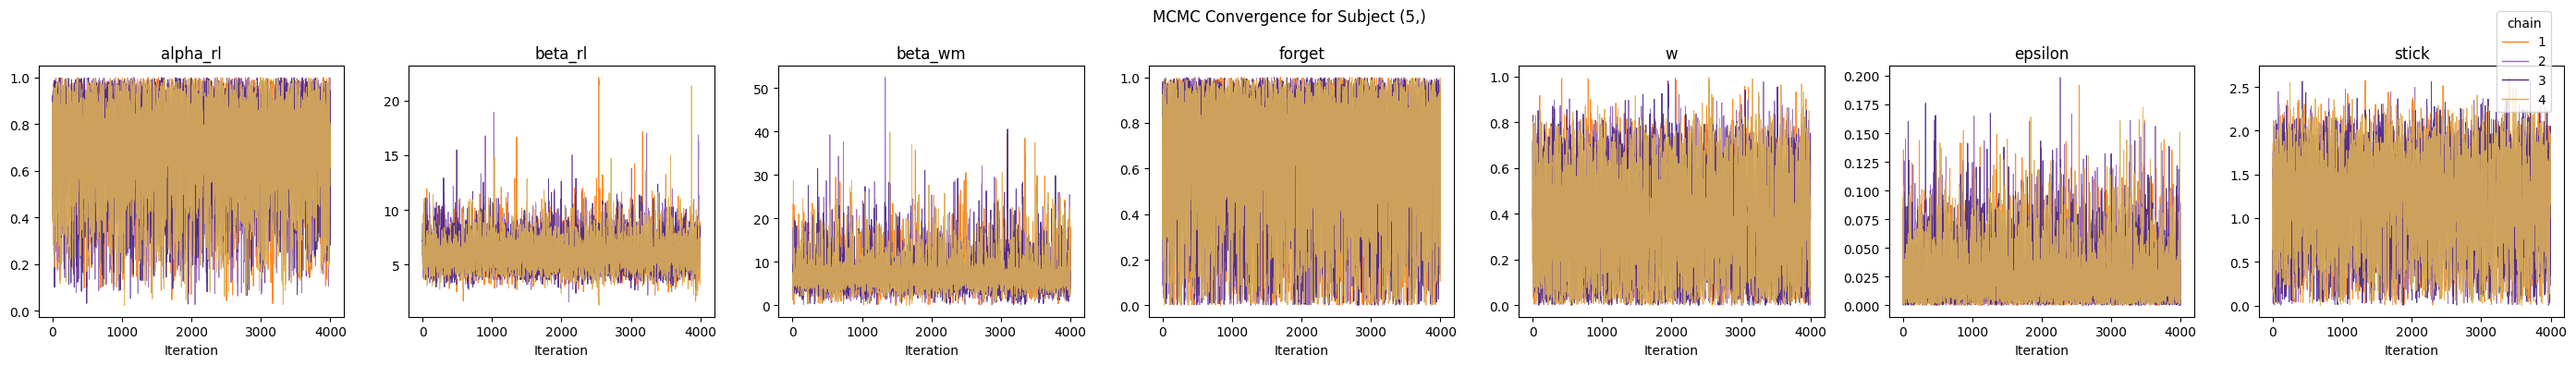


Summary Statistics (including R-hat and ESS):
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_rl  0.697  0.205   0.327    1.000      0.002    0.002   10301.0    7069.0    1.0
beta_rl   6.054  1.514   3.561    8.856      0.017    0.032    8887.0    8468.0    1.0
beta_wm   7.024  3.837   0.359   13.514      0.041    0.076    7530.0    3618.0    1.0
forget    0.618  0.281   0.067    1.000      0.003    0.003    7845.0    3957.0    1.0
w         0.375  0.219   0.000    0.707      0.003    0.001    4681.0    6395.0    1.0
epsilon   0.024  0.023   0.000    0.066      0.000    0.000    8530.0    5972.0    1.0
stick     1.157  0.540   0.106    2.009      0.008    0.004    4269.0    3901.0    1.0


In [32]:
# data = data[data['subno']==5]
results_df = fit_rlwm_foraging_model(data,4,4000)

In [33]:
results_df

,subno,alpha_rl,beta_rl,beta_wm,forget,w,epsilon,stick
0,"(1,)",0.572243,5.028543,11.083226,0.748242,0.394761,0.051125,1.336510
1,"(1,)",0.574149,6.645181,2.365044,0.135014,0.140546,0.040582,1.663488
2,"(1,)",0.402440,4.994264,10.322020,0.833862,0.549473,0.001646,0.873748
3,"(1,)",0.742240,6.069041,8.313413,0.849278,0.675516,0.054309,0.524665
4,"(1,)",0.835166,4.934772,5.475791,0.791449,0.518699,0.027445,2.014695
...,...,...,...,...,...,...,...,...
79995,"(5,)",0.738673,5.795979,8.413102,0.918836,0.022940,0.007929,1.876099
79996,"(5,)",0.769089,5.553764,2.800022,0.915407,0.168355,0.034020,1.476571
79997,"(5,)",0.997944,6.772162,8.066188,0.536354,0.553049,0.004133,0.642158
79998,"(5,)",0.939868,8.543359,5.512342,0.849384,0.374208,0.001844,1.273583


#MLE Calculation

In [ ]:
param_names = ['alpha_rl', 'beta_rl', 'beta_wm', 'forget', 'w', 'epsilon', 'stick']
samples = np.vstack([results_df[param] for param in param_names])

# Perform Kernel Density Estimation
print("Performing Kernel Density Estimation...")
kde = gaussian_kde(samples)
print("KDE calculation finished.")

# Define bounds for each parameter
param_bounds = [
    (1e-6, 1.0 - 1e-6),   # alpha_rl
    (1e-6, 30.0),         # beta_rl
    (1e-6, 30.0),         # beta_wm
    (1e-6, 1.0 - 1e-6),   # forget
    (1e-6, 1.0 - 1e-6),   # w
    (1e-6, 1.0 - 1e-6),   # epsilon
    (-10.0, 10.0)         # stick (wide prior range)
]

def neg_kde(params):
    # Check bounds manually
    for val, (low, high) in zip(params, param_bounds):
        if not (low <= val <= high):
            return np.inf
    try:
        density = kde(params)[0]
        return -density if (math.isfinite(density) and density > 0) else np.inf
    except Exception:
        return np.inf

store = []

for i in range(1000):
    initial_guess = [np.random.uniform(low, high) for (low, high) in param_bounds]
    print(f"Run {i+1}: Initial guess = {dict(zip(param_names, [f'{v:.4f}' for v in initial_guess]))}")

    result = minimize(
        fun=neg_kde,
        x0=initial_guess,
        method='L-BFGS-B',
        bounds=param_bounds,
        options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
    )

    if result.success:
        mle_estimate = result.x
        final_density = kde(mle_estimate)[0]
        print("  Success: " + ", ".join(f"{name}: {val:.6f}" for name, val in zip(param_names, mle_estimate)) +
              f", KDE density: {final_density:.4g}")
        store.append(list(mle_estimate) + [final_density])
    else:
        print(f"  Optimization failed: {result.message}")

# Save to DataFrame
store_results_rlwm = pd.DataFrame(store, columns=param_names + ['density'])


In [35]:
rounded_density = store_results_rlwm['density'].round(1)
store_results_rlwm[rounded_density == rounded_density.max()]

,alpha_rl,beta_rl,beta_wm,forget,w,epsilon,stick,density
165,0.845017,9.473502,7.175707,0.898884,0.862089,0.009919,0.253244,1.399218
306,0.841668,10.924581,7.203986,0.901391,0.855198,0.009838,0.244572,1.417657


In [36]:
# Count occurrences of each rounded density value
rounded_density.value_counts()


,count
density,
0.0,333
1.4,2
1.0,1


In [37]:
data['Patch'] = data['Patch']-1
actions = data['Patch'].values
rewards = data['Reward'].values
N = len(actions)
A = 8
actions

array([0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 3, 5, 6, 7, 6, 0, 3, 4, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 4,
       4, 4, 7, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 7, 6,

#Model Learning Plot

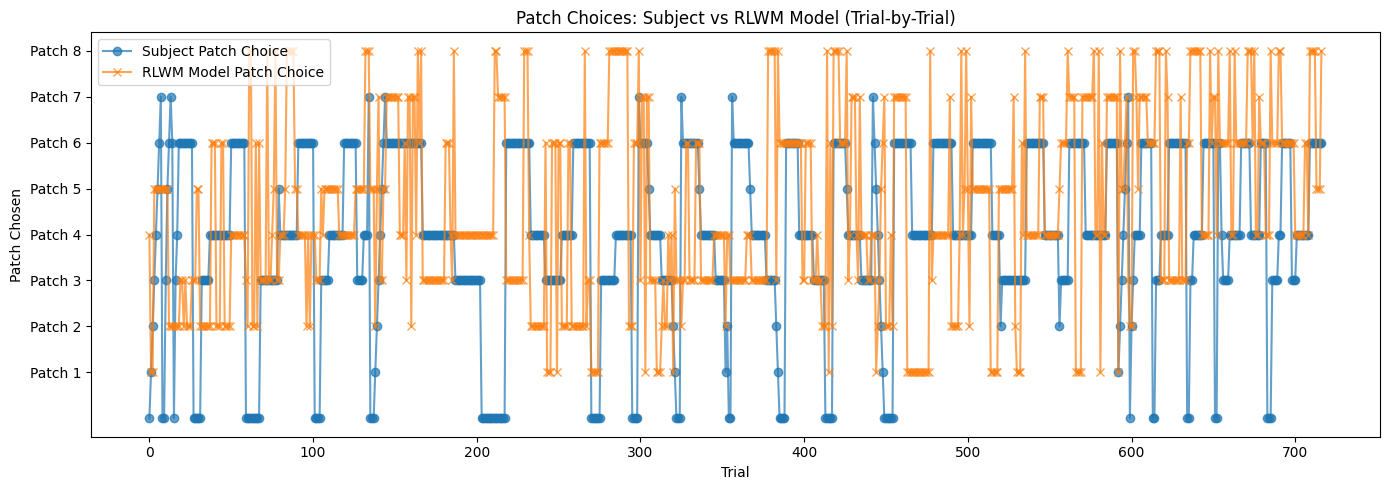

In [38]:
A = len([col for col in data.columns if col.startswith('p')])
patch_reward_cols = [col for col in data.columns if col.startswith('p')]
patch_rewards = data[patch_reward_cols].values  # shape: (N, A)

actions = data['Patch'].values.astype(int) - 1  # convert to 0-based index
rewards = data['Reward'].values
N = len(actions)
reward_scale = 200.0

# ==== 2. RLWM parameters (use estimated MLEs or samples) ====
alpha_rl = 0.868316
beta_rl = 6.090153
beta_wm = 4.578272
forget = 0.006104
w = 0.224626
epsilon = 0.027270
stick = 1.579407

model_choices = []
model_probs = []
reward_prediction_errors = []

Q = np.zeros(A)
WM = np.zeros(A)
prev_choice_vec = np.zeros(A)

for t in range(N):
    policy_rl_logits = beta_rl * Q + stick * prev_choice_vec
    policy_wm_logits = beta_wm * WM + stick * prev_choice_vec

    policy_rl_logits -= np.max(policy_rl_logits)
    policy_wm_logits -= np.max(policy_wm_logits)

    policy_rl = np.exp(policy_rl_logits)
    policy_wm = np.exp(policy_wm_logits)

    policy_rl /= np.sum(policy_rl)
    policy_wm /= np.sum(policy_wm)

    combined_policy = w * policy_wm + (1 - w) * policy_rl
    final_policy = (1 - epsilon) * combined_policy + epsilon / A

    model_probs.append(final_policy.copy())

    model_choice = np.random.choice(A, p=final_policy)
    model_choices.append(model_choice)

    r = rewards[t] / reward_scale
    rpe = r - Q[model_choice]
    reward_prediction_errors.append(rpe)

    Q[model_choice] += alpha_rl * rpe

    WM *= (1 - forget)
    WM[model_choice] = r

    prev_choice_vec[:] = 0
    prev_choice_vec[model_choice] = 1.0

model_choices = np.array(model_choices)
model_probs = np.array(model_probs)
reward_prediction_errors = np.array(reward_prediction_errors)

plt.figure(figsize=(14, 5))
plt.plot(range(N), actions, 'o-', label='Subject Patch Choice', alpha=0.7)
plt.plot(range(N), model_choices, 'x-', label='RLWM Model Patch Choice', alpha=0.7)
plt.yticks(range(A), [f'Patch {i+1}' for i in range(A)])
plt.xlabel('Trial')
plt.ylabel('Patch Chosen')
plt.title('Patch Choices: Subject vs RLWM Model (Trial-by-Trial)')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
total_reward_subject = np.sum(rewards)

model_rewards = []
for t in range(N):
    model_patch = model_choices[t]
    model_reward = patch_rewards[t, model_patch]
    model_rewards.append(model_reward)
total_reward_model = np.sum(model_rewards)

# Mean RPE (reward prediction error)
mean_rpe = np.mean(reward_prediction_errors)

print("Total reward (subject):", total_reward_subject)
print("Total reward (model):", total_reward_model)
print(f"Mean RPE: {mean_rpe * 100:.2f}%")


Total reward (subject): 78930
Total reward (model): 38161
Mean RPE: 0.48%


#AIC Score

In [40]:
def calculate_log_likelihood_rlwm(actions, rewards, alpha, beta, wm_weight, wm_decay, reward_scale=200.0, num_actions=8):
    """
    Log-likelihood function for the RLWM model.
    """
    Q = np.zeros(num_actions)  # RL Q-values
    WM = np.full(num_actions, np.nan)  # WM representation
    total_log_likelihood = 0.0
    N = len(actions)

    for t in range(N):
        a = actions[t]

        # Softmax from both RL and WM
        logits_rl = beta * Q
        logits_rl -= np.max(logits_rl)
        probs_rl = np.exp(logits_rl) / np.sum(np.exp(logits_rl))

        if not np.isnan(WM[a]):
            wm_probs = np.zeros(num_actions)
            wm_probs[a] = 1.0
        else:
            wm_probs = np.ones(num_actions) / num_actions

        final_probs = wm_weight * wm_probs + (1 - wm_weight) * probs_rl

        prob_a = final_probs[a]
        epsilon = 1e-10
        total_log_likelihood += np.log(max(prob_a, epsilon))

        # Reward prediction error (RL)
        scaled_reward = rewards[t] / reward_scale
        rpe = scaled_reward - Q[a]
        Q[a] += alpha * rpe

        # Update WM
        WM = wm_decay * WM
        WM[a] = scaled_reward

    return total_log_likelihood

def calculate_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

mle_alpha = 0.839178         # Learning rate
mle_beta = 6.08756           # Inverse temp (RL)
mle_wm_weight = 0.475497     # WM weight (w)
mle_wm_decay = 0.809417      # Forgetting (decay)
# Optionally add others if used in model (e.g., stickiness or epsilon), but not in log-likelihood here

num_estimated_params = 4  # Only alpha, beta_rl, wm_weight, and forget used in log-likelihood

data['Patch'] = data['Patch'] - 1  # 0-index actions
subjects = data['subno'].unique()
total_log_likelihood = 0.0

print(f"Calculating RLWM log-likelihood using:")
print(f"alpha = {mle_alpha}, beta = {mle_beta}, wm_weight = {mle_wm_weight}, wm_decay = {mle_wm_decay}")

for sub in subjects:
    sub_data = data[data['subno'] == sub]
    actions_sub = sub_data['Patch'].values
    rewards_sub = sub_data['Reward'].values

    if len(actions_sub) == 0:
        print(f"Subject {sub}: No data found. Skipping.")
        continue

    ll_sub = calculate_log_likelihood_rlwm(
        actions_sub, rewards_sub,
        alpha=mle_alpha,
        beta=mle_beta,
        wm_weight=mle_wm_weight,
        wm_decay=mle_wm_decay
    )

    print(f"Subject {sub}: Log-Likelihood = {ll_sub:.4f}")
    # total_log_likelihood += ll_sub
    total_log_likelihood = ll_sub

print(f"\nTotal Log-Likelihood (all subjects): {total_log_likelihood:.4f}")

aic_score = calculate_aic(total_log_likelihood, num_estimated_params)
print(f"Number of estimated parameters (k): {num_estimated_params}")
print(f"AIC score for RLWM: {aic_score:.3f}")


Calculating RLWM log-likelihood using:
alpha = 0.839178, beta = 6.08756, wm_weight = 0.475497, wm_decay = 0.809417
Subject 1: Log-Likelihood = -65.6787
Subject 2: Log-Likelihood = -68.1861
Subject 3: Log-Likelihood = -65.6420
Subject 4: Log-Likelihood = -60.0846
Subject 5: Log-Likelihood = -63.6829

Total Log-Likelihood (all subjects): -63.6829
Number of estimated parameters (k): 4
AIC score for RLWM: 135.366


In [41]:
def plot_mixture_weights_over_time(w, forget, n_trials=100, set_size=3):
    """
    Plots the dynamic mixture weights (WM vs RL) over time in RLWM model.

    Args:
        w (float): Initial WM weight (0 to 1).
        forget (float): Forgetting parameter (0 to 1), higher = faster decay of WM.
        n_trials (int): Number of trials to simulate.
        set_size (int): Set size (affects WM decay).

    Returns:
        None (shows plot)
    """
    trials = np.arange(n_trials)

    # Exponential decay of WM over time due to forgetting
    wm_weight = w * np.exp(-forget * trials / set_size)
    rl_weight = 1 - wm_weight

    # Normalize to ensure they sum to 1 at each time point
    total = wm_weight + rl_weight
    wm_weight /= total
    rl_weight /= total

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.stackplot(trials, wm_weight, rl_weight, labels=['WM Weight', 'RL Weight'],
                  colors=['#56B4E9', '#E66157'], alpha=0.9)

    plt.title(f"RLWM Mixture Weight Composition Over Time (Set Size {set_size})")
    plt.xlabel("Trial")
    plt.ylabel("Weight Proportion")
    plt.ylim(0, 1.05)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


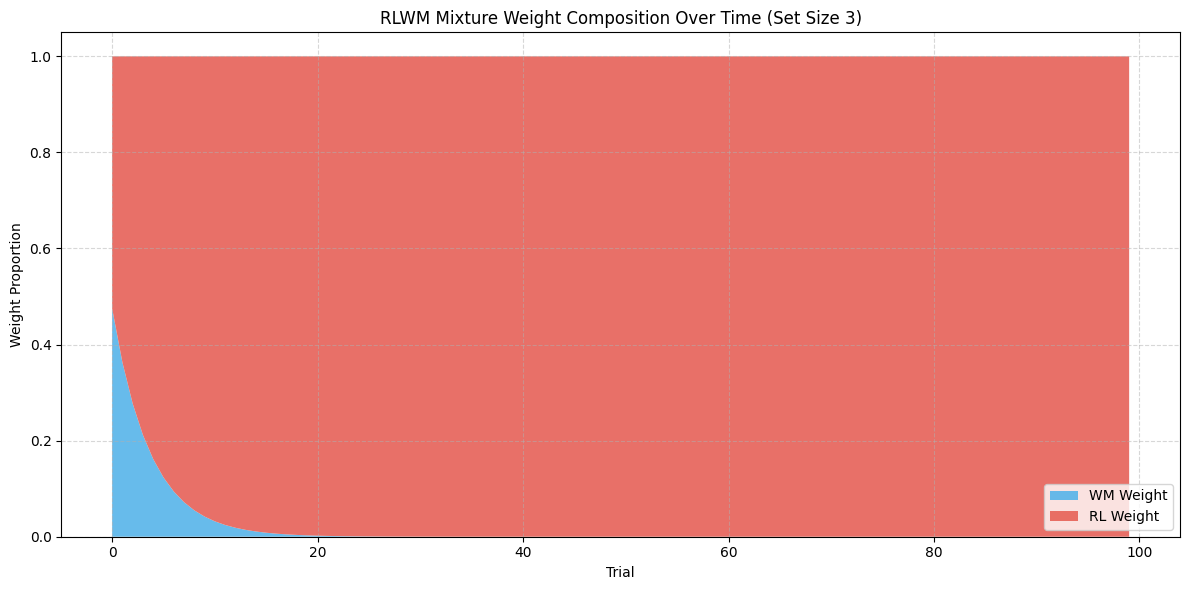

In [42]:
best_w = 0.475497
best_forget = 0.809417
plot_mixture_weights_over_time(w=best_w, forget=best_forget, n_trials=100, set_size=3)


<ipython-input-43-93b977fb32a8>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_subjects)


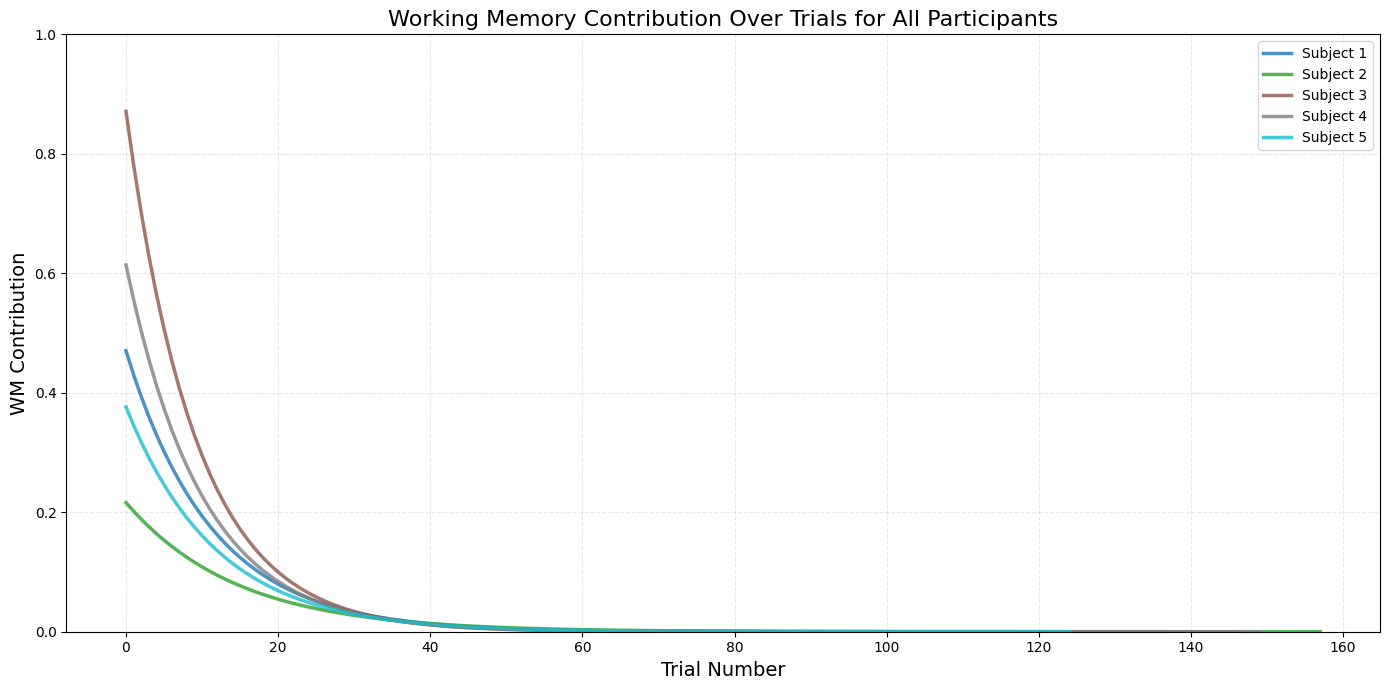

In [43]:
def plot_wm_contribution_all_participants(data, results_df):
    """
    Plots RLWM's WM contribution trial-wise for all participants.
    Different color is used for each participant.

    Args:
        data (DataFrame): The foraging data containing trials for all participants
        results_df (DataFrame): DataFrame containing MCMC samples for all participants
                               should have 'subno', 'w', and 'forget' columns
    """
    # Get unique participants
    subjects = data['subno'].unique()
    n_subjects = len(subjects)

    # Set up colormap
    cmap = plt.cm.get_cmap('tab10', n_subjects)

    plt.figure(figsize=(14, 7))

    # Get the maximum number of trials across all participants for x-axis
    max_trials = data.groupby('subno').size().max()
    trials = np.arange(max_trials)

    # For each participant
    for i, subject in enumerate(subjects):
        # Get subject data
        sub_data = data[data['subno'] == subject]
        n_trials = len(sub_data)

        # Get median parameter values for this subject
        sub_results = results_df[results_df['subno'] == subject]
        w = sub_results['w'].median()
        forget = sub_results['forget'].median()

        # Get set size (number of unique patches)
        set_size = len(sub_data['Patch'].unique())

        # Calculate WM contribution over trials
        wm_contribution = w * np.exp(-forget * np.arange(n_trials) / set_size)

        # Plot with different color for each participant
        plt.plot(np.arange(n_trials), wm_contribution,
                 label=f'Subject {subject}',
                 color=cmap(i),
                 linewidth=2.5,
                 alpha=0.8)

    plt.title('Working Memory Contribution Over Trials for All Participants', fontsize=16)
    plt.xlabel('Trial Number', fontsize=14)
    plt.ylabel('WM Contribution', fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Load all subjects data (replace with correct path)
all_data = pd.read_csv('/content/Foraging_data.csv')
all_data['Reward'] = pd.to_numeric(all_data['Reward'], errors='coerce').fillna(0).astype(int)
all_data['subno'] = pd.to_numeric(all_data['subno'], errors='coerce').fillna(0).astype(int)
all_data['Patch'] = pd.to_numeric(all_data['Patch'], errors='coerce').fillna(0).astype(int)

plot_wm_contribution_all_participants(all_data, results_df)



In [56]:
def plot_combined_mixture_weight_boxplot(data, results_df, n_time_steps=10):
    import matplotlib.pyplot as plt
    import numpy as np

    all_box_data = [[] for _ in range(n_time_steps)]
    for subject_id in data['subno'].unique():
        subject_data = data[data['subno'] == subject_id]
        subject_results = results_df[results_df['subno'] == subject_id]
        n_trials = len(subject_data)
        set_size = len(subject_data['Patch'].unique())
        time_steps = np.linspace(0, n_trials-1, n_time_steps).astype(int)
        if len(subject_results) > 0:
            w_samples = subject_results['w'].values
            forget_samples = subject_results['forget'].values
            for i in range(len(w_samples)):
                w = w_samples[i]
                forget = forget_samples[i]
                trajectory = w * np.exp(-forget * np.arange(n_trials) / set_size)
                for j in range(n_time_steps):
                    all_box_data[j].append(trajectory[time_steps[j]])
    plt.figure(figsize=(12, 6))
    plt.boxplot(all_box_data, positions=np.arange(1, n_time_steps+1), widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.8), medianprops=dict(color='navy'),
                whiskerprops=dict(color='navy'), capprops=dict(color='navy'), showfliers=False)
    means = [np.mean(data) for data in all_box_data]
    plt.plot(range(1, n_time_steps+1), means, 'o-', color='orange', markersize=8, linewidth=2, label='Mean')
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Mixture Weight', fontsize=14)
    plt.title('Combined Mixture Weight Distribution Over Time (All Subjects)', fontsize=16)
    plt.ylim(0, 1.0)
    plt.xticks(range(1, n_time_steps+1))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

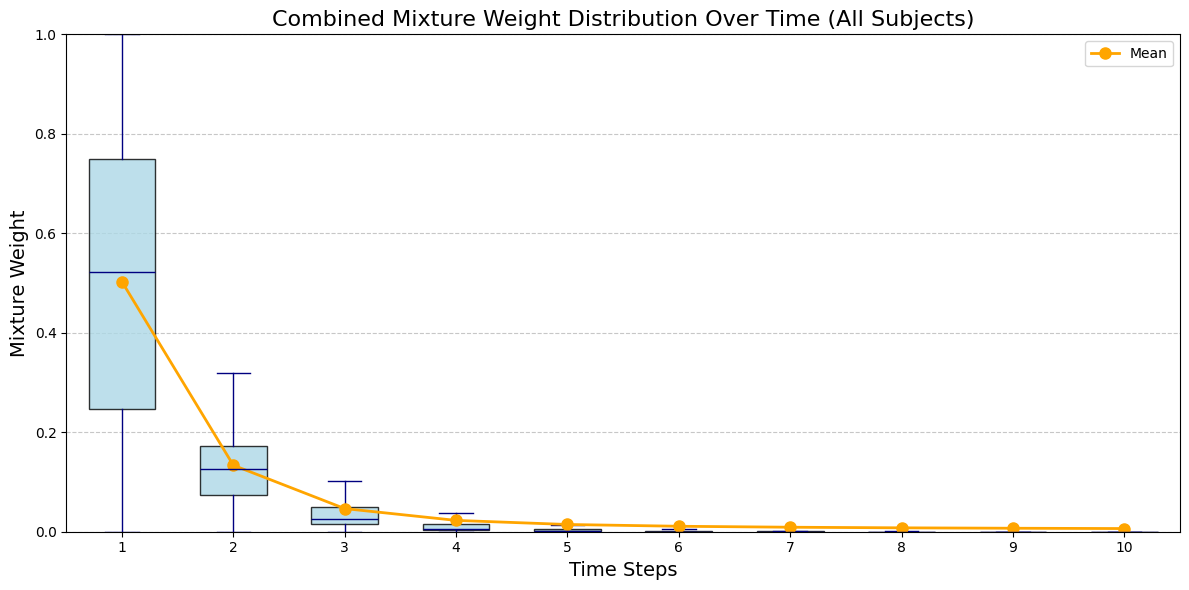

In [57]:
plot_combined_mixture_weight_boxplot(data, results_df)

In [45]:
results_df.to_csv('rlwm_mcmc_results.csv', index=False)
print("Saved MCMC results to rlwm_mcmc_results.csv")

# Save MLE results
store_results_rlwm.to_csv('rlwm_mle_results.csv', index=False)
print("Saved MLE results to rlwm_mle_results.csv")

# Save model predictions and actual choices
model_data = pd.DataFrame({
    'trial': range(N),
    'actual_choice': actions,
    'model_choice': model_choices,
    'reward': rewards,
    'model_reward': model_rewards,
    'rpe': reward_prediction_errors
})
model_data.to_csv('rlwm_model_predictions.csv', index=False)
print("Saved model predictions to rlwm_model_predictions.csv")

# Save AIC score and log likelihood
aic_data = pd.DataFrame({
    'log_likelihood': [total_log_likelihood],
    'aic_score': [aic_score],
    'num_parameters': [num_estimated_params]
})
aic_data.to_csv('rlwm_model_fit.csv', index=False)
print("Saved model fit statistics to rlwm_model_fit.csv")


Saved MCMC results to rlwm_mcmc_results.csv
Saved MLE results to rlwm_mle_results.csv
Saved model predictions to rlwm_model_predictions.csv
Saved model fit statistics to rlwm_model_fit.csv
